In [1]:
from models.dataset import Dataset, DatasetReality
from models.pipeline import prep_data, train_classifier
from ana.visual import STAT, ROC, FEAT

import numpy as np
import random
np.random.seed(7)
random.seed(7)

import warnings
from sklearn.linear_model import LogisticRegression
warnings.simplefilter('ignore')

## for evaluation
import matplotlib.pyplot as plt

In [2]:
# dataset, X, y, pairs, index = prep_data(Dataset, shuffle_interval=3)
dataset = prep_data(Dataset, test=0.1, shuffle=True, seed=None,
                    text_idf=True, categ_idf=False,
                    cross_simi=True,
                    norm_simi=True, suppress_freq=1)

 - Preparing data..
 - Initialize image encoder..
  - Set feature names..
  - Build category level idf..
  - Build similarity normalizer..
 - Initialize text encoder..
 - Initialize joint encoder..
 - Set feature names..
- Fetching training data..
     Fetched - [82]
- Fetching test data..
     Fetched - [10]
  - Data train shape (246, 10443)
  - Data test shape (30, 10443)


In [3]:
dataset_r = prep_data(DatasetReality,
                      index_tup=(dataset.index_train,
                                 dataset.index_test), 
                      categ_idf=False, 
                      cross_simi=True,
                      norm_simi=True)

 - Preparing data..
 - Initialize image encoder..
  - Set feature names..
  - Build category level idf..
  - Build similarity normalizer..
 - Initialize text encoder..
 - Initialize joint encoder..
 - Set feature names..
 - Build fake layers..
 - Set feature names..
- Fetching training data..
     Fetched - [82]
- Fetching test data..
     Fetched - [10]
  - Data train shape (164, 311)
  - Data test shape (20, 311)


### dataset inspection

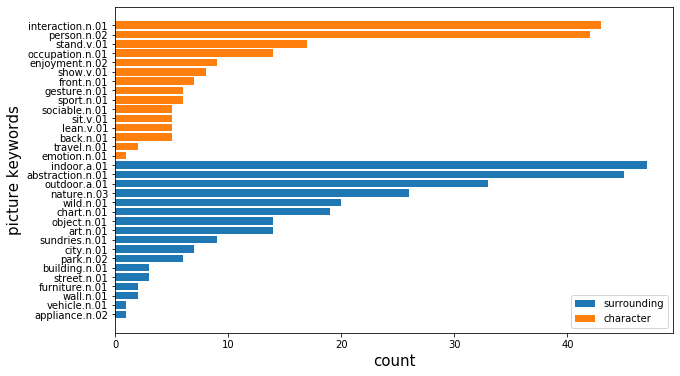

In [48]:
## picture categories occurrences

from tools.image_process import getLayerNames
from tools.common import getFiles
keywords_list = []
root_keywords_list = []
for img in getFiles('images', ext='.svg'):
    layers = getLayerNames(img)
    keywords_list.append(dataset.img_encoder.layer2keyword(layers))
    root_keywords_list.append(dataset.img_encoder.layer2rootKey(layers))
    
from collections import defaultdict
from rules.category import surrouding_dict, person_dict
from tools.common import getNestedKey
keywords_S = defaultdict(int)
keywords_P = defaultdict(int)
for keys in keywords_list:
    for key in keys:
        if key in getNestedKey(surrouding_dict):
            keywords_S[key] += 1
        elif key in getNestedKey(person_dict):
            keywords_P[key] += 1
        else:
            raise ValueError
plt.figure(figsize=(10,6))
plt.barh(*zip(*sorted(keywords_S.items(), key=lambda x:x[-1])),
         label='surrounding')
plt.barh(*zip(*sorted(keywords_P.items(), key=lambda x:x[-1])),
         label='character')
plt.ylabel('picture keywords', fontsize=fontsize)
plt.xlabel('count', fontsize=fontsize)
plt.legend()
plt.savefig('results/picture-occurrence')
plt.show()

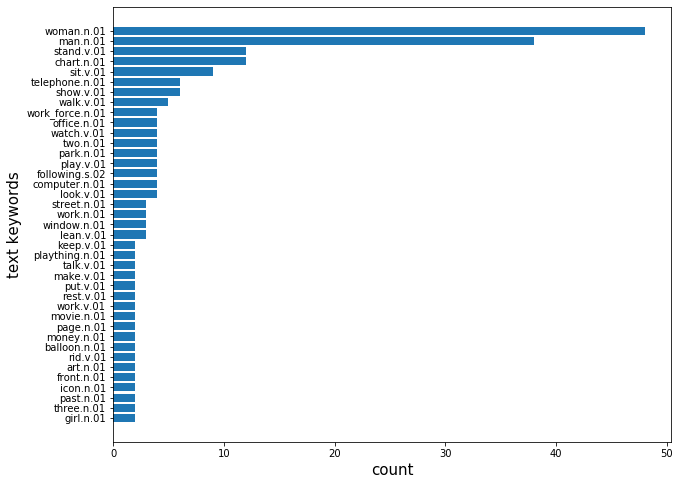

In [46]:
## text keywords with occurrences > 1
from tools.common import getFiles
from collections import defaultdict
vocabs = defaultdict(int)
for fileName in getFiles('text', ext='.txt'):
    with open(fileName, 'r') as f:
        sent = f.read()
        for token in dataset.txt_encoder.tokenizer(sent):
            vocabs[token] += 1
plt.figure(figsize=(10,8))
plt.barh(*zip(*list(filter(lambda x: x[1]>1, sorted(vocabs.items(), key=lambda x:x[-1])))))
fontsize=15
plt.ylabel('text keywords', fontsize=fontsize)
plt.xlabel('count', fontsize=fontsize)
plt.savefig('results/text-occurrence')
plt.show()

In [54]:
# length of feature of reasonability dataset
16+17+4+16*17+1

# length of feature of consistency dataset
5+16+17+16*17+298+298*(16+17)

10442

--------- top 10
_P_front.n.01-front.n.01_ 3.6375861597263857
_P_back.n.01-back.n.01_ 3.6375861597263857
_S_street.n.01-street.n.01_ 3.6375861597263857
_S_city.n.01-city.n.01_ 3.6375861597263857
_S_art.n.01-art.n.01_ 3.6375861597263857
_S_chart.n.01-chart.n.01_ 3.6375861597263857
_P_show.v.01-show.v.01_ 3.258096538021482
_P_sit.v.01-sit.v.01_ 3.258096538021482
_P_lean.v.01-lean.v.01_ 3.258096538021482
_P_stand.v.01-stand.v.01_ 3.258096538021482
--------- tail 10
_P_interaction.n.01-deer.n.01_ 0.5930637220029626
_S_abstraction.n.01-turbine.n.01_ 0.5930637220029626
_P_gesture.n.01-turbine.n.01_ 0.5465437063680699
_P_sport.n.01-deer.n.01_ 0.5465437063680699
_P_travel.n.01-turbine.n.01_ 0.5465437063680699
_P_sociable.n.01-deer.n.01_ 0.5465437063680699
_P_abstraction.n.01-deer.n.01_ 0.5465437063680699
_S_abstraction.n.01-deer.n.01_ 0.5465437063680699
_P_gesture.n.01-deer.n.01_ 0.5020919437972361
_P_travel.n.01-deer.n.01_ 0.5020919437972361


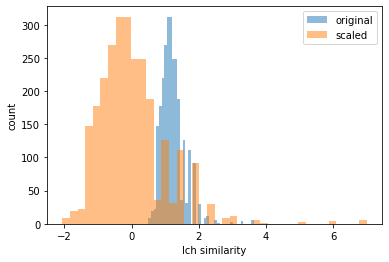

In [42]:
## hist of simis between category and keywords

tups = sorted(filter(lambda x: x[1]>0, dataset.joint_encoder.simi_.items()), key=lambda x: x[1])[::-1]
print('--------- top 10')
for feat, val in tups[:10]:
    print(feat, val)
print('--------- tail 10')
for feat, val in tups[-10:]:
    print(feat, val)

simis = np.array(list(dataset.joint_encoder.simi_.values()))

simis = simis[simis!=0]
plt.hist(simis, bins=40, alpha=0.5, label='original')

from tools.math import Normalizer
normalizer = Normalizer()
normalizer.fit(simis)
plt.hist(normalizer.transform(simis), bins=40, alpha=0.5,
         label='scaled')
plt.xlabel('lch similarity')
plt.ylabel('count')
plt.legend()
plt.savefig('results/cross-simi')
plt.show()

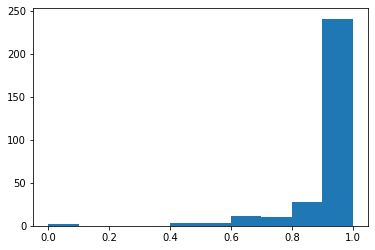

In [55]:
## text idfs hist
txt_idf = np.array(list(dataset.txt_encoder.idf_.values())).reshape(-1,1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# normalizer.fit(txt_idf)
txt_idf_norm = scaler.fit_transform(txt_idf)
# def norm2(arr):
#     return np.sqrt(sum(arr**2) / len(arr))
plt.hist(txt_idf_norm)
plt.show()

### evaluation - consisstency discriminator 

In [64]:
clf = train_classifier(dataset,
                       class_weight={1: 1, 0: 0.1},
                       C=1)

In [230]:
# higher class weight of 0 will always make it easier in term of precision
# because of imbalance

# loose C to encourage more features
# l1 learns sparse representation
y_true = dataset.data_test[:,-1].toarray().flatten()
y_prob = clf.predict_proba(dataset.data_test[:,:-1])[:,1]

10 positives out of 30 test examples
Overall accuracy: 0.400000
*Recall(thresh=0.5)/AccuracyOf1: 0.900000
Precision(thresh=0.5): 0.346154
AccuracyOf0(thresh=0.5): 0.400000


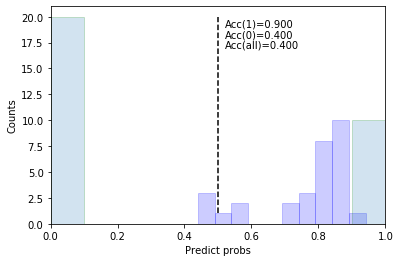

In [234]:
### the bars move to the right would be better?
suffix = 'temp'
STAT(y_true, y_prob, path='STAT_%s' % suffix)

In [233]:
# when shut down category idf, performance improves
# because the test set contains many chart thing..
# it should be right

precision | recall | F1 | threshold
------------------------------
0.345 | 1.000 | 0.513 | 0.453
0.333 | 0.900 | 0.486 | 0.494
0.346 | 0.900 | 0.500 | 0.546
0.375 | 0.900 | 0.529 | 0.695
0.364 | 0.800 | 0.500 | 0.742
0.381 | 0.800 | 0.516 | 0.759
0.421 | 0.800 | 0.552 | 0.799
0.412 | 0.700 | 0.519 | 0.824
0.462 | 0.600 | 0.522 | 0.825
0.500 | 0.600 | 0.545 | 0.830
0.545 | 0.600 | 0.571 | 0.847
0.625 | 0.500 | 0.556 | 0.867
0.750 | 0.300 | 0.429 | 0.876
0.667 | 0.200 | 0.308 | 0.885
1.000 | 0.100 | 0.182 | 0.942
------------------------------


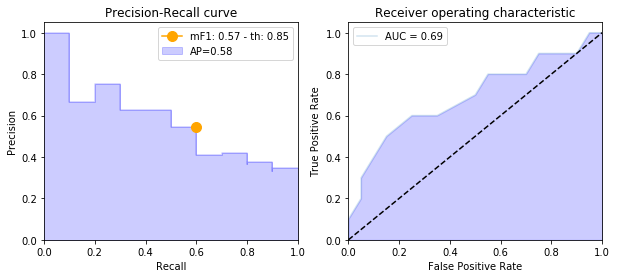

In [232]:
ROC(y_true, y_prob, path='ROC_%s' % suffix)

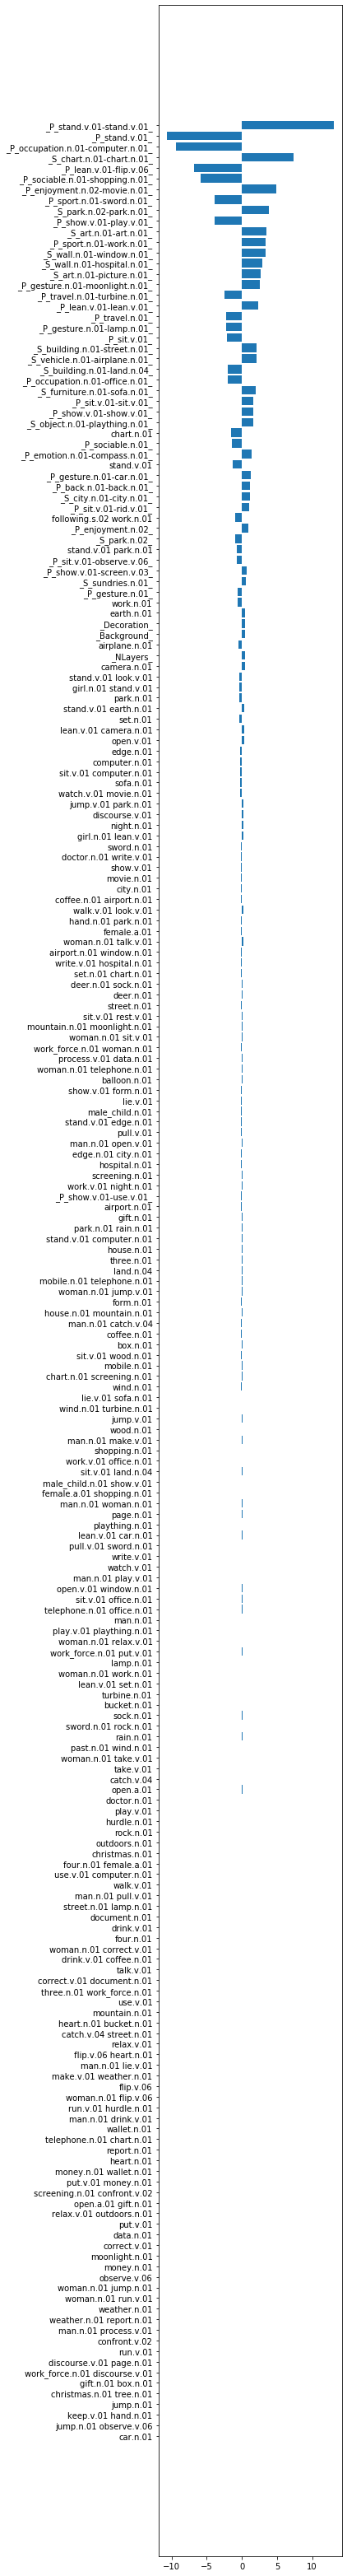

In [186]:
FEAT(dataset, clf, path='FEAT_%s' % suffix)

### error analysis - consistency discriminator

In [8]:
y_true.astype(int)

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0])

In [9]:
(y_prob > 0.687).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1])

In [10]:
y_prob

array([0.58481366, 0.57154211, 0.61854462, 0.61931428, 0.61931428,
       0.61931428, 0.58481366, 0.57154211, 0.58481366, 0.23886008,
       0.60562418, 0.26974359, 0.63946162, 0.65191065, 0.60562418,
       0.88489954, 0.63946162, 0.88489954, 0.82251494, 0.30538492,
       0.82203806, 0.9005642 , 0.60640332, 0.20853314, 0.68722989,
       0.63946162, 0.65619668, 0.70855047, 0.22910718, 0.70855047])

In [11]:
index[ind_test:]/3

array([72.        , 72.33333333, 72.66666667, 86.        , 86.33333333,
       86.66666667, 14.        , 14.33333333, 14.66666667, 57.        ,
       57.33333333, 57.66666667, 23.        , 23.33333333, 23.66666667,
       83.        , 83.33333333, 83.66666667, 67.        , 67.33333333,
       67.66666667, 25.        , 25.33333333, 25.66666667, 68.        ,
       68.33333333, 68.66666667, 47.        , 47.33333333, 47.66666667])

In [12]:
coeff_dict = dict(zip(dataset.features_, clf.coef_.tolist()[0]))

In [54]:
from scipy import sparse

ind = 3
print(dataset.txt_encoder.tokenizer(pairs[ind_test:][ind][1]))
print(dataset.img_encoder.layer2keyword(pairs[ind_test:][ind][0]))

vec = dataset.encode(*pairs[ind_test:][ind])
tuples = []
for i in np.where(vec!=0)[0]:
    feature = dataset.features_[i]
    tuples.append((feature, vec[i], coeff_dict[feature]))
for f, v, c in sorted(tuples, key=lambda x: abs(x[1]))[::-1]:
    print('%40s % 10.6f %.6f' % (f,v,c))

# bigram doesn't act in the similarity.
# thus bigrams are not visible here since we filter out zero features

['woman.n.01', 'keep.v.01', 'plaything.n.01']
['indoor.a.01', 'object.n.01', 'sundries.n.01', 'person.n.02', 'sit.v.01']
          _S_object.n.01-plaything.n.01_  10.491570 0.000000
                  _P_sit.v.01-keep.v.01_   9.868253 0.000000
        _S_sundries.n.01-plaything.n.01_   7.738709 0.000000
          _P_person.n.02-plaything.n.01_   6.692120 0.000000
                keep.v.01 plaything.n.01   4.839452 0.000000
             _P_sit.v.01-plaything.n.01_  -4.793330 0.000000
               _P_person.n.02-keep.v.01_  -4.793330 0.000000
             _S_sundries.n.01-keep.v.01_  -4.793330 0.000000
               _S_object.n.01-keep.v.01_  -4.793330 0.000000
          _S_indoor.a.01-plaything.n.01_  -4.793330 0.000000
               _S_indoor.a.01-keep.v.01_  -4.793330 0.000000
                    woman.n.01 keep.v.01   4.433987 0.000000
                          plaything.n.01   4.433987 0.000000
                               keep.v.01   4.433987 0.000000
                         

In [7]:
index = 87
img = 'images/%i.svg' % index
txt = 'text/%i.txt' % index
dataset.getOneLayerSent(txt, img)

(['A1', 'A2114', 'A322'], 'A woman holds a toy.\n')

In [16]:
## 0
# only woman and n_layers carries non-zero value as a feature
# caused by insufficient data

In [21]:
print(dataset.joint_encoder.idf_['plaything.n.01'])
print(dataset.joint_encoder.simi_['_S_object.n.01-plaything.n.01_'])
print(dataset.joint_encoder.simi_normalizer.transform(dataset.joint_encoder.simi_['_S_object.n.01-plaything.n.01_']))
print(dataset.joint_encoder.simi_normalizer.mean)
print(dataset.joint_encoder.simi_normalizer.std)

4.433987204485146
2.2512917986064953
2.3661705326503535
0.7060029855494958
0.6530758420552714


In [22]:
## 1
# object and plaything are moderately similar
# plaything is very rare (only appear once/twice (didn't check))
# though this feature in this datus is large, it didn't take any effect

In [46]:
pairs[ind_test:]

[(['A2211', 'A3211'], 'A woman looks in the window.\n'),
 (['A2211', 'A3211'], 'A man is watching a movie.\n'),
 (['A1', 'A312'], 'A woman looks in the window.\n'),
 (['A1', 'A2114', 'A322'], 'A woman holds a toy.\n'),
 (['A1', 'A2114', 'A322'], 'A woman works in an office.\n'),
 (['A1', 'A2121', 'A3212'], 'A woman holds a toy.\n'),
 (['A1', 'A325'], 'A woman is showing love'),
 (['A1', 'A325'], 'A man drinks coffee at the airport window'),
 (['A2121', 'A3213'], 'A woman is showing love'),
 (['A1', 'A312'], 'A woman is standing to annotate.\n'),
 (['A1', 'A312'], 'A man is riding a bike on the street.\n'),
 (['A1', 'A2222', 'A324'], 'A woman is standing to annotate.\n'),
 (['A1', 'A2211', 'A315'], 'A man is riding a bike on the street.\n'),
 (['A1', 'A2211', 'A315'], 'A woman is playing with a bunch of balloons.\n'),
 (['A2122', 'A312'], 'A man is riding a bike on the street.\n'),
 (['A1', 'A2122', 'A312'], 'A woman sat to rest.\n'),
 (['A1', 'A2122', 'A312'], 'There are three trademar

In [21]:
dataset.getOneLayerSent(txt_name='text/72.txt',
                        img_name='images/72.svg')

(['A1', 'A2222', 'A325'], 'A man and a woman jump to celebrate.')

### reality discriminator

In [52]:
clf_r = train_classifier(dataset_r,
                         class_weight={1: 1, 0: 0.3},
                         C=30)
# low negative weight will suppress largest coeffcients, leading to better results

In [53]:
y_true = dataset_r.data_test[:,-1].toarray().flatten()
y_prob = clf_r.predict_proba(dataset_r.data_test[:,:-1])[:,1]

10 positives out of 20 test examples
Overall accuracy: 0.850000
*Recall(thresh=0.5)/AccuracyOf1: 0.800000
Precision(thresh=0.5): 0.888889
AccuracyOf0(thresh=0.5): 0.850000


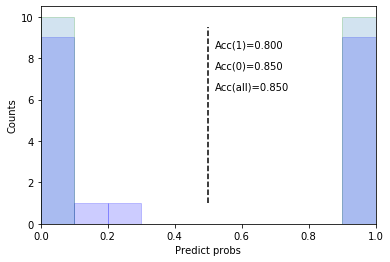

In [54]:
suffix = 'temp1'
STAT(y_true, y_prob, path='realitySTAT_%s' % suffix)

precision | recall | F1 | threshold
------------------------------
0.769 | 1.000 | 0.870 | 0.085
0.750 | 0.900 | 0.818 | 0.087
0.818 | 0.900 | 0.857 | 0.160
0.900 | 0.900 | 0.900 | 0.217
0.889 | 0.800 | 0.842 | 0.951
0.875 | 0.700 | 0.778 | 0.960
0.857 | 0.600 | 0.706 | 0.971
0.833 | 0.500 | 0.625 | 0.975
0.800 | 0.400 | 0.533 | 0.980
0.750 | 0.300 | 0.429 | 0.992
0.667 | 0.200 | 0.308 | 1.000
1.000 | 0.200 | 0.333 | 1.000
1.000 | 0.100 | 0.182 | 1.000
------------------------------


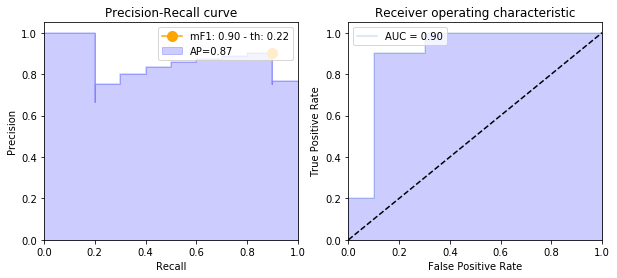

In [55]:
ROC(y_true, y_prob, path='realityROC_%s' % suffix)

In [62]:
dataset_r.img_encoder.simi_

{'_S_room.n.01-P_interaction.n.01_': 0.9985288301111273,
 '_S_room.n.01-P_occupation.n.01_': 0.9985288301111273,
 '_S_room.n.01-P_abstraction.n.01_': 0.9295359586241757,
 '_S_room.n.01-P_emotion.n.01_': 1.072636802264849,
 '_S_room.n.01-P_sociable.n.01_': 0.9295359586241757,
 '_S_room.n.01-P_travel.n.01_': 0.8649974374866046,
 '_S_room.n.01-P_enjoyment.n.02_': 0.9985288301111273,
 '_S_room.n.01-P_person.n.02_': 1.4403615823901665,
 '_S_room.n.01-P_stand.v.01_': 0.0,
 '_S_room.n.01-P_lean.v.01_': 0.0,
 '_S_room.n.01-P_back.n.01_': 1.2396908869280152,
 '_S_room.n.01-P_front.n.01_': 1.072636802264849,
 '_S_room.n.01-P_sit.v.01_': 0.0,
 '_S_room.n.01-P_sport.n.01_': 0.9295359586241757,
 '_S_room.n.01-P_show.v.01_': 0.0,
 '_S_room.n.01-P_gesture.n.01_': 0.8649974374866046,
 '_S_object.n.01-P_interaction.n.01_': 1.4403615823901665,
 '_S_object.n.01-P_occupation.n.01_': 1.4403615823901665,
 '_S_object.n.01-P_abstraction.n.01_': 1.3350010667323402,
 '_S_object.n.01-P_emotion.n.01_': 1.55814461

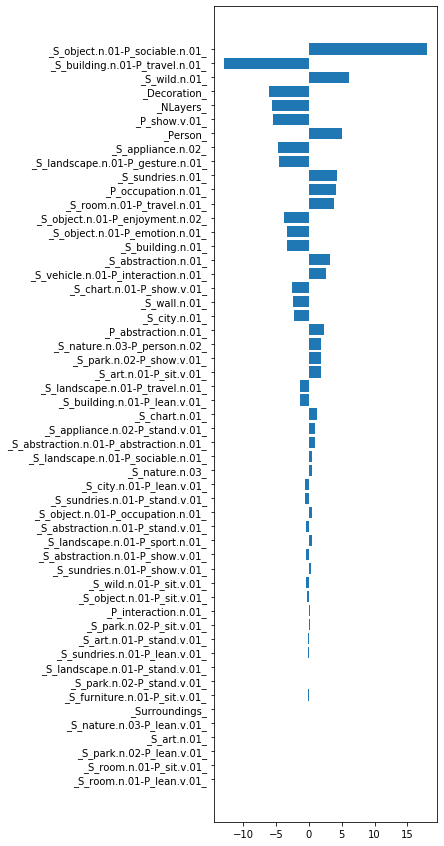

In [57]:
FEAT(dataset_r, clf_r, path='realityFEAT_%s' % suffix)

wild - gesture ++ (play in the park)

surrounding - object? --
person - interaction? --

if object stuff, interaction is rare?

In [10]:
# todo - unseen keywords

why almost all keywords contain chart..

high lamb -> less charts things

### error analysis - predictor

In [65]:
from models.model import Discriminator
discriminator = Discriminator(dataset, clf, dataset_r, clf_r)
# getMaxContrbutionFeature(['A2121', 'A323', 'A4'], 'A woman holds a toy.\n', discriminator, lamb=0.7)

from models.model import categMetric
categMetric(discriminator, lamb=0.8)

 [0] ------ 73 -----

Layers:  ['A2211', 'A3211']
Keywords:  ['landscape.n.01', 'city.n.01', 'street.n.01', 'person.n.02', 'stand.v.01', 'lean.v.01']
Sentence: A woman looks in the window.
Tokens: ['woman.n.01', 'look.v.01', 'window.n.01']
Seen tokens: ['woman.n.01', 'look.v.01', 'window.n.01']

Predicted layers:  ['A1', 'A2114', 'A314', 'A4']
Predicted keywords: ['room.n.01', 'object.n.01', 'sundries.n.01', 'interaction.n.01', 'sociable.n.01'] Prob: 0.919178
Max contributed features: [('real', '_S_object.n.01-P_sociable.n.01_', 0.7380303756807826, 17.958493042013533), ('cons', '_NLayers_', 4.0, 0.35613017476115477), ('real', '_Person_', 1.0, 5.010654766616407), ('real', '_S_sundries.n.01_', 1.0, 4.33342273102261), ('real', '_P_interaction.n.01_', 1.0, 0.21478641065111143), ('cons', '_P_interaction.n.01_', 1.0, 0.03930114193091661), ('real', '_Surroundings_', 1.0, -0.02211934251827821), ('real', '_Decoration_', 1.0, -6.0013366549135085), ('real', '_NLayers_', 4.0, -5.65229295162883)]
A

Layers:  ['A1', 'A2222', 'A316']
Keywords:  ['landscape.n.01', 'nature.n.03', 'wild.n.01', 'interaction.n.01', 'enjoyment.n.02']
Sentence: A woman puts up a lantern.
Tokens: ['woman.n.01', 'put.v.01', 'lantern.n.01']
Seen tokens: ['woman.n.01', 'put.v.01']

Predicted layers:  ['A1', 'A2114', 'A314', 'A4']
Predicted keywords: ['room.n.01', 'object.n.01', 'sundries.n.01', 'interaction.n.01', 'sociable.n.01'] Prob: 0.919178
Max contributed features: [('real', '_S_object.n.01-P_sociable.n.01_', 0.7380303756807826, 17.958493042013533), ('cons', '_NLayers_', 4.0, 0.35613017476115477), ('real', '_Person_', 1.0, 5.010654766616407), ('real', '_S_sundries.n.01_', 1.0, 4.33342273102261), ('real', '_P_interaction.n.01_', 1.0, 0.21478641065111143), ('cons', '_P_interaction.n.01_', 1.0, 0.03930114193091661), ('real', '_Surroundings_', 1.0, -0.02211934251827821), ('real', '_Decoration_', 1.0, -6.0013366549135085), ('real', '_NLayers_', 4.0, -5.65229295162883)]
Acc: 0.756757 - Precision: 0.444444 - Re

0.4943991955756662

### errata
26: gesture -> show?

### observation


* "man and woman -> interaction" needs bigram embedding - but the pairwise similarity is missing here

* some keywords, eg. charts, are weighted too much and can easily be put forward -- single tokens seems only detrimental?

* hope that length of sentence could help determine the number of layers? # simply add a sentence length feature doesn't work

* replace indoor with room doesn't improve because it's idf reweighted

* seems that good discriminator doesn't necessarily mean good predictor. When turning off category idf, the discriminator (consistency) looks good, but the predictions get worse

### optimize lamb 

In [21]:
from models.model import Discriminator
import dill
discriminator = Discriminator(dataset, clf, dataset_r, clf_r)
with open('results/discriminator.pkl', 'wb') as f:
    dill.dump(discriminator, f)

In [23]:
# from tools.text_process import LemmaTokenizer
# from models.model import Discriminator
# from models.model import categMetric
# import numpy as np
# import dill
import warnings
warnings.simplefilter('ignore')

# discriminator = Discriminator.unpickle()
mF1s = []
lambs = np.arange(0,1.2,0.2)
for lamb in lambs:
    mF1s.append(categMetric(discriminator, lamb=lamb,
                            verbose=False))

 [0] ------ 73 -----

Acc: 0.810811 - Precision: 0.666667 - Recall: 0.250000 - F1: 0.363636
 [1] ------ 87 -----

Acc: 0.810811 - Precision: 0.666667 - Recall: 0.250000 - F1: 0.363636
 [2] ------ 15 -----

Acc: 0.972973 - Precision: 1.000000 - Recall: 0.750000 - F1: 0.857143
 [3] ------ 58 -----

Acc: 0.837838 - Precision: 0.333333 - Recall: 0.200000 - F1: 0.250000
 [4] ------ 24 -----

Acc: 0.756757 - Precision: 0.333333 - Recall: 0.125000 - F1: 0.181818
 [5] ------ 84 -----

Acc: 0.756757 - Precision: 0.333333 - Recall: 0.125000 - F1: 0.181818
 [6] ------ 68 -----

Acc: 0.837838 - Precision: 1.000000 - Recall: 0.333333 - F1: 0.500000
 [7] ------ 26 -----

Acc: 0.837838 - Precision: 1.000000 - Recall: 0.333333 - F1: 0.500000
 [8] ------ 69 -----

Acc: 0.756757 - Precision: 0.333333 - Recall: 0.125000 - F1: 0.181818
 [9] ------ 48 -----

Acc: 0.864865 - Precision: 0.333333 - Recall: 0.250000 - F1: 0.285714
mean F1: 0.366558
 [0] ------ 73 -----

Acc: 0.702703 - Precision: 0.285714 - Re

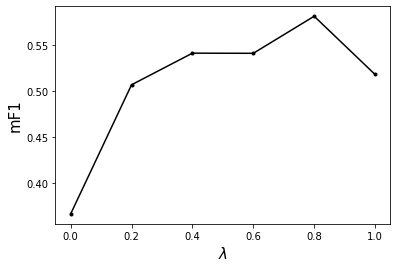

In [24]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(lambs, mF1s,'k.-')
plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('mF1', fontsize=15)
plt.savefig('results/predictor_lamb-metric')
plt.show()

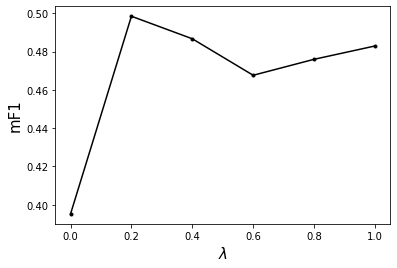

In [45]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(lambs, mF1s,'k.-')
plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('mF1', fontsize=15)
plt.savefig('results/predictor_lamb-metric')
plt.show()

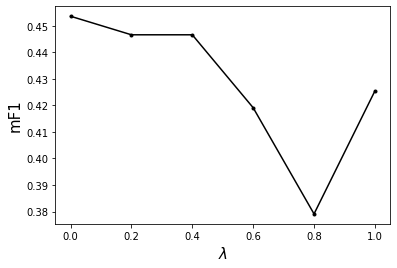

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(lambs, mF1s,'k.-')
plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('mF1', fontsize=15)
plt.show()

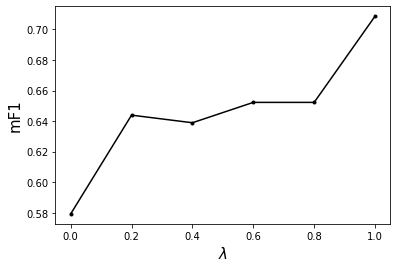

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(lambs, mF1s,'k.-')
plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('mF1', fontsize=15)
plt.show()

* which features contribute to the prob?
* is similarity really necessary? no negative cross-simi pairs will contribute

    * simi -> rule based
    * one-hot -> learning

In [75]:
from models.model import Discriminator
discriminator = Discriminator.unpickle()

from models.model import exhaustiveSearch
layers, prob = exhaustiveSearch('A man is showing a chart.',
                                 discriminator,
                                 lamb=0.8)
print(layers, prob)

['A2121', 'A324'] 0.9959498762690687


In [76]:
import glob
import random
def getMaterial(layer):
    l = glob.glob('material/%s*.png' % layer)
    return random.choice(l)

from tools.image_process import stack_svgs
stack_svgs([getMaterial(layer) for layer in layers])

from IPython.display import SVG, display
from IPython.display import HTML
def show_svg():
    # display(HTML("<style>.container { width:100% !important; }</style>"))
    # style = "<style>svg{width:50% !important;height:50% !important;}</style>"
    # display(HTML(style))
    display(SVG('stack.svg'))
show_svg()

Canvas size: (969, 899)
File: material/A2121_(10).png
File: material/A324_(6).png


In [32]:
## Check feature and vector are consistent

In [31]:
layers, sentence = dataset.getOneLayerSent(txt_name='text/1.txt', img_name='images/6.svg')
print(layers)
print(dataset.img_encoder.layer2keyword(layers))
print(sentence)
list(filter(lambda x: x[1]!=0, zip(dataset.joint_encoder.features_, dataset.joint_encoder.encode(layers, sentence))))

['A2112', 'A311']
['indoor.a.01', 'object.n.01', 'appliance.n.02', 'interaction.n.01', 'occupation.n.01']
A man looks at his chart with his back.



[('_S_object.n.01_back.n.01_', 1.845826690498331),
 ('_S_object.n.01_chart.n.01_', 1.6916760106710724),
 ('_S_object.n.01_man.n.01_', 1.845826690498331),
 ('_S_appliance.n.02_back.n.01_', 1.1526795099383855),
 ('_S_appliance.n.02_chart.n.01_', 1.072636802264849),
 ('_S_appliance.n.02_man.n.01_', 1.2396908869280152),
 ('_P_interaction.n.01_back.n.01_', 1.1526795099383855),
 ('_P_interaction.n.01_chart.n.01_', 1.4403615823901665),
 ('_P_interaction.n.01_man.n.01_', 1.1526795099383855),
 ('_P_occupation.n.01_back.n.01_', 1.1526795099383855),
 ('_P_occupation.n.01_chart.n.01_', 1.4403615823901665),
 ('_P_occupation.n.01_man.n.01_', 1.1526795099383855)]

## XGB

In [9]:
import xgboost as xgb

In [10]:
w = np.array([1 if y_ == 1 else 0.3 for y_ in y[:ind_test]])
dtrain = xgb.DMatrix(X[:ind_test], label=y[:ind_test], weight=w, feature_names=dataset.features_)

dtest = xgb.DMatrix(X[ind_test:],
                    label=y[ind_test:],
                    feature_names=dataset.features_,)

In [11]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [12]:
num_round = 20
bst = xgb.train(param, dtrain, num_round,
                evallist, early_stopping_rounds=3)
# ypred = bst.predict(dtest)

[0]	eval-auc:0.5	train-auc:0.601725
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 3 rounds.
[1]	eval-auc:0.565	train-auc:0.672814
[2]	eval-auc:0.6025	train-auc:0.708209
[3]	eval-auc:0.615	train-auc:0.734347
[4]	eval-auc:0.6325	train-auc:0.759816
[5]	eval-auc:0.6625	train-auc:0.770152
[6]	eval-auc:0.6675	train-auc:0.774836
[7]	eval-auc:0.61	train-auc:0.783946
[8]	eval-auc:0.665	train-auc:0.801643
[9]	eval-auc:0.635	train-auc:0.809823
[10]	eval-auc:0.665	train-auc:0.814173
[11]	eval-auc:0.6625	train-auc:0.819416
[12]	eval-auc:0.6625	train-auc:0.827112
[13]	eval-auc:0.645	train-auc:0.829045
[14]	eval-auc:0.635	train-auc:0.82793
[15]	eval-auc:0.635	train-auc:0.831797
[16]	eval-auc:0.6325	train-auc:0.834994
[17]	eval-auc:0.6575	train-auc:0.835849
[18]	eval-auc:0.6575	train-auc:0.840534
[19]	eval-auc:0.6425	train-auc:0.839307


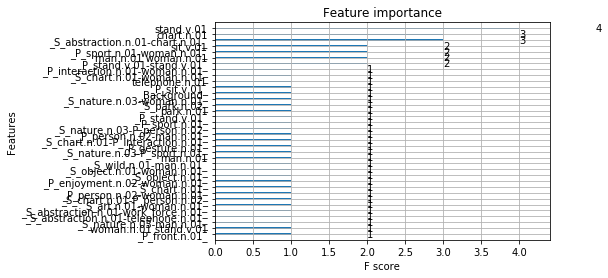

In [13]:
xgb.plot_importance(bst)

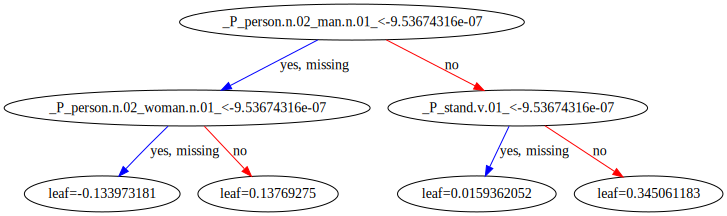

In [30]:
xgb.to_graphviz(bst, num_trees=19)

In [24]:
import glob
import re
index = []
for filename in glob.glob('images/*.svg'):
    index.append(int(re.findall(r'\d+', filename)[0]))
index.sort()
print(index)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]


In [22]:
assert(sorted(index) == list(range(1,93)))